In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from tqdm.auto import trange

# Functions for creating a dog

In [2]:
WALKING_TIME = 0
EATING_TIME = 0
PLAYING_TIME = 0

food_consumption_rate = 1.0 / (30 * 3600)
affection_consumption_rate = 1.0 / (50 * 3600)
walking_fat_converge_rate = 0.2
walking_affection_converge_rate = 0.4
playing_fat_converge_rate = 0.1
playing_affection_converge_rate = 0.20
eating_food_increase = 0.6
eating_fat_increase = 0.25

In [3]:
def transform_to_dec(value, dec=10):
    return np.floor(dec*value)/dec

def apply_decreasing_rate(value: float, rate: float) -> float:
    """
    Apply a decreasing rate to a value
    :param value: current value
    :param rate: per second
    :return: updated value
    """
    return value - (60 * rate)

def converge(value: float, target: float, ratio: float) -> float:
    diff: float = (target - value) * ratio
    return value + diff

def update_walking(dog_table_row):
    update_fat = converge(dog_table_row.iloc[0]['fat'], 0.0, walking_fat_converge_rate)
    update_affection = converge(dog_table_row.iloc[0]['affection'], 1.0, walking_affection_converge_rate)
    return (update_fat, update_affection)

def update_feeding(dog_table_row):
    update_food = min(dog_table_row.iloc[0]['food'] + eating_food_increase, 1.0)
    update_fat = min(dog_table_row.iloc[0]['fat'] + eating_fat_increase, 1.0)
    return (update_food, update_fat)

def update_playing(dog_table_row):
    update_fat = converge(dog_table_row.iloc[0]['fat'], 0.0, playing_fat_converge_rate)
    update_affection = converge(dog_table_row.iloc[0]['affection'], 1.0, playing_affection_converge_rate)
    return (update_fat, update_affection)

def update_food(dog_table_row):
    return transform_to_dec(max(
        0.0,
        apply_decreasing_rate(dog_table_row.iloc[0]['food'], food_consumption_rate)
    ))

def update_affection(dog_table_row):
    return transform_to_dec(max(
        0.0,
        apply_decreasing_rate(dog_table_row.iloc[0]['affection'], affection_consumption_rate)
    ))

def update_happiness(dog_table_row) -> float:  # between 0 and 1
    return min(
        dog_table_row.iloc[0]['food'],
        1.0 - dog_table_row.iloc[0]['fat'],
        dog_table_row.iloc[0]['affection']
    )

def update_alive(dog_table_row):
    return dog_table_row.iloc[0]['alive'] & (dog_table_row.iloc[0]['happiness'] > 0.0)

def new_state_after_1_minute(dog_table, action_taken='NO ACTION'):
    
    dog_table_row = dog_table.tail(1)
    new_state_dog_id = dog_table_row.iloc[0]['dog_id']
    
    new_state_food = update_food(dog_table_row)
    new_state_fat = dog_table_row.iloc[0]['fat']
    new_state_affection = update_affection(dog_table_row)
    
    new_state_last_action_taken = dog_table_row.iloc[0]['last_action_taken']
    new_state_can_action_be_taken = dog_table_row.iloc[0]['can_action_be_taken']
    new_state_minutes_since_last_action = dog_table_row.iloc[0]['minutes_since_last_action']
    
    new_state_minute = dog_table_row.iloc[0]['minute'] + 1
    new_state_minutes_since_last_action = dog_table_row.iloc[0]['minutes_since_last_action'] + 1
    
    new_state_happiness = update_happiness(dog_table_row)
    new_state_alive = update_alive(dog_table_row)
    
    if ((action_taken != 'NO ACTION') & (dog_table_row.iloc[0]['can_action_be_taken'])):
        new_state_last_action_taken = action_taken
        new_state_can_action_be_taken = False
        new_state_minutes_since_last_action = 0
    
    if ((dog_table_row.iloc[0]['last_action_taken'] == 'WALKING') &
        (dog_table_row.iloc[0]['minutes_since_last_action'] == WALKING_TIME)):
        new_state_fat, new_state_affection = update_walking(dog_table_row)
        new_state_last_action_taken = 'NO ACTION'
        new_state_can_action_be_taken = True
        new_state_minutes_since_last_action = 0        

    if ((dog_table_row.iloc[0]['last_action_taken'] == 'FEEDING') &
        (dog_table_row.iloc[0]['minutes_since_last_action'] == EATING_TIME)):
        new_state_food, new_state_fat = update_feeding(dog_table_row)
        new_state_last_action_taken = 'NO ACTION'
        new_state_can_action_be_taken = True
        new_state_minutes_since_last_action = 0

    if ((dog_table_row.iloc[0]['last_action_taken'] == 'PLAYING') &
        (dog_table_row.iloc[0]['minutes_since_last_action'] == PLAYING_TIME)):
        new_state_fat, new_state_affection = update_playing(dog_table_row)
        new_state_last_action_taken = 'NO ACTION'
        new_state_can_action_be_taken = True
        new_state_minutes_since_last_action = 0
        
    dog_table = dog_table.append({
        'dog_id': new_state_dog_id,
        'minute': new_state_minute,
        'happiness': new_state_happiness,
        'food': new_state_food,
        'fat': new_state_fat,
        'affection': new_state_affection,
        'alive': new_state_alive,
        'can_action_be_taken': new_state_can_action_be_taken, 
        'last_action_taken': new_state_last_action_taken,
        'minutes_since_last_action': new_state_minutes_since_last_action
        }, ignore_index=True)
    
    return dog_table

# Functions for RL

## Initialize dog

In [19]:
def init_dog_table():

    dog_table = pd.DataFrame(columns=[
        'dog_id', 'minute',
        'happiness', 'food', 'fat', 'affection',
        'alive', 'can_action_be_taken', 'last_action_taken', 'minutes_since_last_action'
    ])

    #dog_table = dog_table.append({
    #    'dog_id': 1, 'minute': 0,
    #    'happiness': 0,
    #    'food': transform_to_dec(1), 
    #    'fat': transform_to_dec(0), 
    #    'affection': transform_to_dec(1),
    #    'alive': True, 'can_action_be_taken': True, 'last_action_taken': 'NO ACTION', 'minutes_since_last_action': 0
    #    }, ignore_index=True)

    dog_table = dog_table.append({
        'dog_id': 1, 'minute': 0,
        'happiness': 0,
        'food': transform_to_dec(random.random()), 
        'fat': transform_to_dec(random.random()), 
        'affection': transform_to_dec(random.random()),
        'alive': True, 'can_action_be_taken': True, 'last_action_taken': 'NO ACTION', 'minutes_since_last_action': 0
        }, ignore_index=True)
    
    dog_table['happiness'] = update_happiness(dog_table)
    
    return dog_table

## Choose action

In [5]:
# epsilon = 0.3

def choose_action(state, Q, action_space, epsilon):
    state_q = get_state_q(state,0)
    if np.random.uniform(0, 1) < epsilon:
        action = random.choices(range(len(action_space)), k = 1)[0]
    else:
        action = np.argmax(Q[state_q, :])
    return action

## Run an episode

In [6]:
def create_episode(Q, max_steps, epsilon):
    
    dog_table = init_dog_table()
    state = dog_table.tail(1)

    t = 0
    while ((state.iloc[0]['alive']) & (t < max_steps)):
        t += 1
        action = choose_action(
            state = state,
            Q = Q,
            action_space = action_space,
            epsilon = epsilon
        )
        dog_table = new_state_after_1_minute(dog_table, action_taken = action_space[action])
        state = dog_table.tail(1)

    return dog_table

## Update Q function

In [7]:
def get_state_q(current_state, t):
    return int('{:01d}{:01d}{:01d}'.format(
        min(9,int(current_state.iloc[t]['food']*10)),
        min(9,int(current_state.iloc[t]['fat']*10)),
        min(9,int(current_state.iloc[t]['affection']*10))
    ))

In [8]:
# Function to learn the Q-value
def update(Q, state_t, reward_t, action_t, state_t_1, gamma, alpha):
    
    Q[state_t, action_t] = Q[state_t, action_t] + alpha * (reward_t + gamma * max(Q[state_t_1,]) - Q[state_t, action_t])
    
    return Q

## Define reward

In [9]:
def define_reward(state, cnt_limit = 20):
    
    dog_table_next_hour = state.copy()
    cnt = 0
    
    while ((dog_table_next_hour.tail(1).iloc[0]['alive']) & (cnt < cnt_limit)):
        cnt += 1
        dog_table_next_hour = new_state_after_1_minute(dog_table_next_hour, action_taken='NO ACTION')

    average_happiness = dog_table_next_hour['happiness'].sum()/cnt_limit
    
    return average_happiness

## Plots

In [10]:
def intermediate_plots(len_steps_plot, all_overall_reward_t):
    
    # Create some mock data
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('episodes')
    ax1.set_ylabel('nber steps', color=color)
    ax1.plot(range(len(len_steps_plot)), len_steps_plot, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('average reward', color=color)  # we already handled the x-label with ax1
    ax2.plot(range(len(all_overall_reward_t)), all_overall_reward_t, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

In [11]:
def display_analyse_Q(Q):
    
    analyse_Q = pd.DataFrame(columns=[
        'state_id', 'food_id', 'fat_id', 'affection_id',
        'no_action', 'walking', 'feeding', 'playing',
    ])

    for i in trange(Q.shape[0]):
        analyse_Q = analyse_Q.append({
            'state_id': int(i),
            'food_id': int(np.floor(i/100)),
            'fat_id': int(np.floor(i/10 % 10)),
            'affection_id': int(np.floor(i % 10)),
            'no_action': Q[i,0],
            'walking': Q[i,1],
            'feeding': Q[i,2],
            'playing': Q[i,3]
            }, ignore_index=True)

    analyse_Q.groupby('food_id').agg({
        'no_action': 'mean',
        'walking': 'mean',
        'feeding': 'mean',
        'playing': 'mean'
    }).plot()

    analyse_Q.groupby('fat_id').agg({
        'no_action': 'mean',
        'walking': 'mean',
        'feeding': 'mean',
        'playing': 'mean'
    }).plot()

    analyse_Q.groupby('affection_id').agg({
        'no_action': 'mean',
        'walking': 'mean',
        'feeding': 'mean',
        'playing': 'mean'
    }).plot()

# This is where things are done

In [12]:
observation_space_n = 10*10*10
action_space = ['NO ACTION', 'WALKING', 'FEEDING', 'PLAYING']
action_space_n = len(action_space)

In [13]:
Q = np.full(
    shape=(observation_space_n, action_space_n),
    fill_value=3.25
)

In [14]:
Q_previous = Q.copy()
all_overall_reward = []
all_overall_reward_plot = []
all_overall_reward_t = []
all_overall_reward_t_plot = []
len_steps = []
len_steps_plot = []
nber_steps = 0

In [15]:
max_steps = 1000
epsilon_initial = 0.5
alpha_initial = 1
gamma = 1
convergence = False

Iter.   82000 - Steps   581132 - Eps. 1.000000 - Alp. 1.000000 - Dist. 63.23522 - Total R. 01.422 - Avg R. 0.126


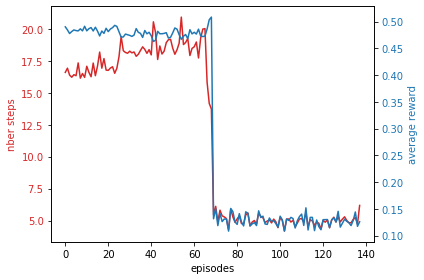

Iter.   83000 - Steps   588075 - Eps. 1.000000 - Alp. 1.000000 - Dist. 251.31676 - Total R. 01.771 - Avg R. 0.138


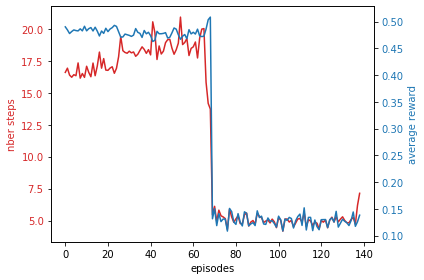

Iter.   84000 - Steps   594806 - Eps. 1.000000 - Alp. 1.000000 - Dist. 351.07837 - Total R. 01.954 - Avg R. 0.150


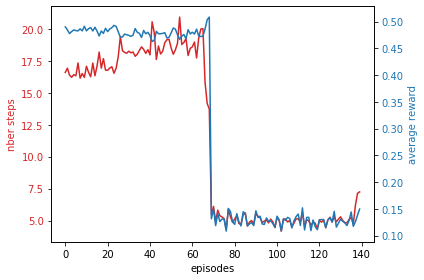

Iter.   85000 - Steps   601986 - Eps. 1.000000 - Alp. 1.000000 - Dist. 446.85343 - Total R. 01.455 - Avg R. 0.133


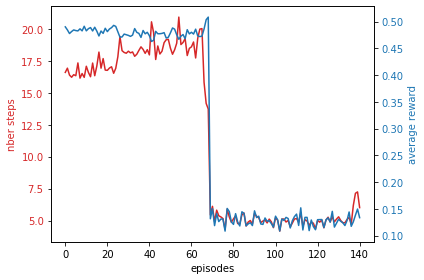

Iter.   86000 - Steps   609044 - Eps. 1.000000 - Alp. 1.000000 - Dist. 508.77185 - Total R. 01.846 - Avg R. 0.140


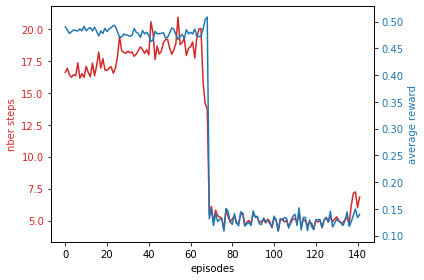

Iter.   87000 - Steps   615718 - Eps. 1.000000 - Alp. 1.000000 - Dist. 507.76456 - Total R. 01.913 - Avg R. 0.161


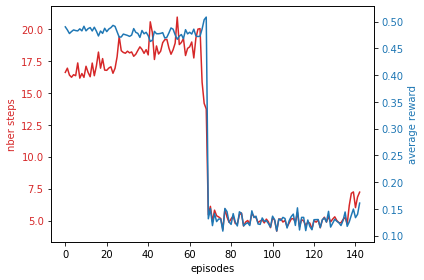

Iter.   88000 - Steps   622943 - Eps. 1.000000 - Alp. 1.000000 - Dist. 537.55297 - Total R. 02.031 - Avg R. 0.158


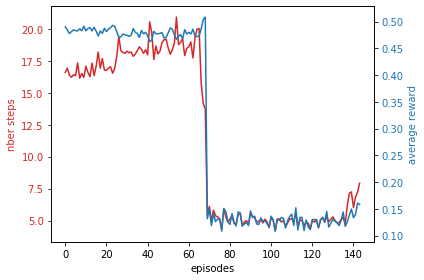

Iter.   89000 - Steps   630072 - Eps. 1.000000 - Alp. 1.000000 - Dist. 571.80936 - Total R. 01.481 - Avg R. 0.130


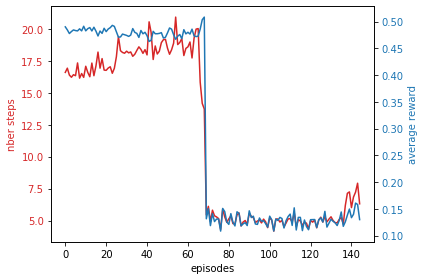

Iter.   90000 - Steps   636824 - Eps. 1.000000 - Alp. 1.000000 - Dist. 544.08551 - Total R. 01.737 - Avg R. 0.138


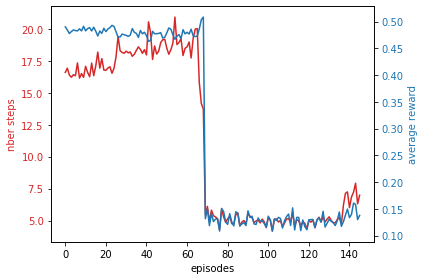


Iter.   91000 - Steps   643758 - Eps. 1.000000 - Alp. 1.000000 - Dist. 568.24805 - Total R. 01.980 - Avg R. 0.146


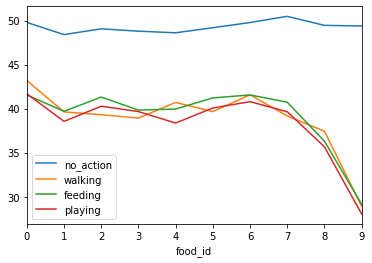

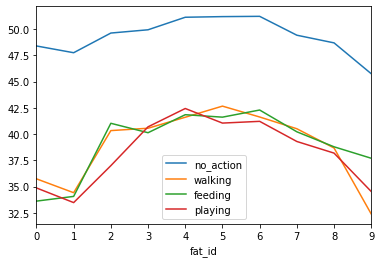

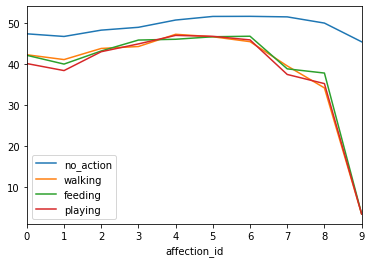

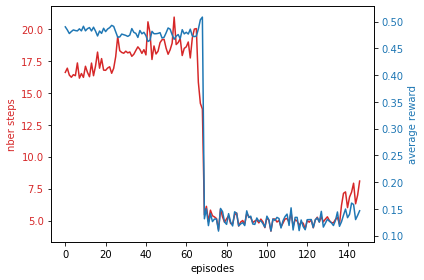

Iter.   92000 - Steps   650609 - Eps. 1.000000 - Alp. 1.000000 - Dist. 585.04029 - Total R. 01.550 - Avg R. 0.137


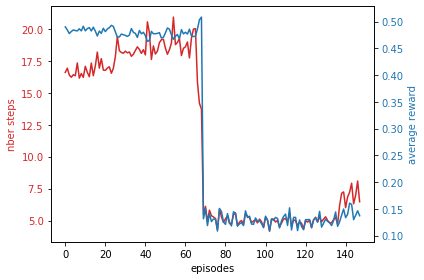

Iter.   93000 - Steps   657748 - Eps. 1.000000 - Alp. 1.000000 - Dist. 621.21136 - Total R. 02.337 - Avg R. 0.163


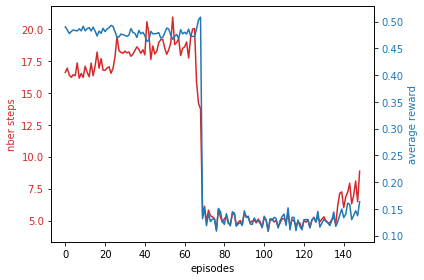

Iter.   94000 - Steps   664677 - Eps. 1.000000 - Alp. 1.000000 - Dist. 614.57043 - Total R. 01.652 - Avg R. 0.146


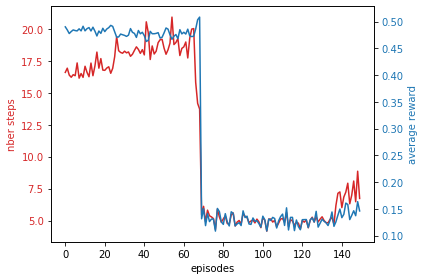

Iter.   95000 - Steps   671518 - Eps. 1.000000 - Alp. 1.000000 - Dist. 581.30288 - Total R. 01.894 - Avg R. 0.138


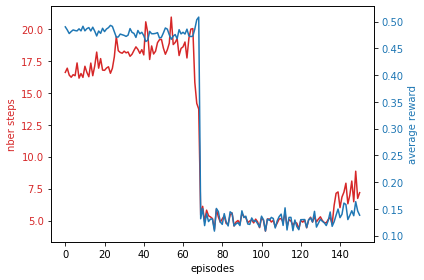

Iter.   96000 - Steps   677752 - Eps. 1.000000 - Alp. 1.000000 - Dist. 549.60963 - Total R. 01.514 - Avg R. 0.134


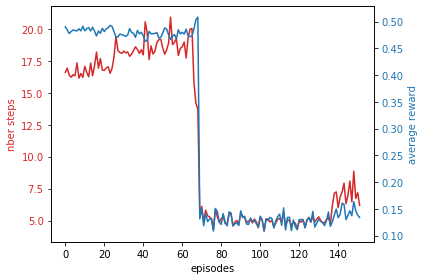

Iter.   97000 - Steps   685029 - Eps. 1.000000 - Alp. 1.000000 - Dist. 604.62731 - Total R. 02.025 - Avg R. 0.156


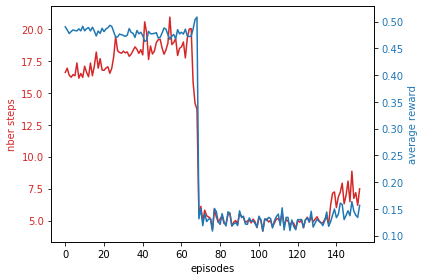

Iter.   98000 - Steps   691797 - Eps. 1.000000 - Alp. 1.000000 - Dist. 538.87130 - Total R. 01.751 - Avg R. 0.143


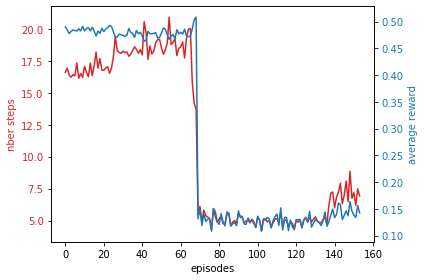

Iter.   99000 - Steps   698905 - Eps. 1.000000 - Alp. 1.000000 - Dist. 622.91076 - Total R. 01.909 - Avg R. 0.149


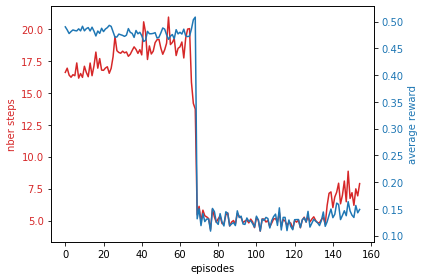

Iter.  100000 - Steps   706024 - Eps. 1.000000 - Alp. 1.000000 - Dist. 617.90620 - Total R. 01.257 - Avg R. 0.127


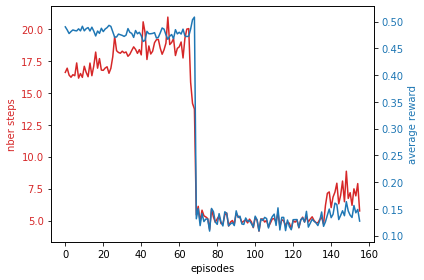


Iter.  101000 - Steps   713202 - Eps. 1.000000 - Alp. 1.000000 - Dist. 623.28601 - Total R. 01.483 - Avg R. 0.135


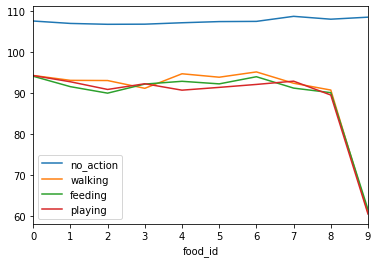

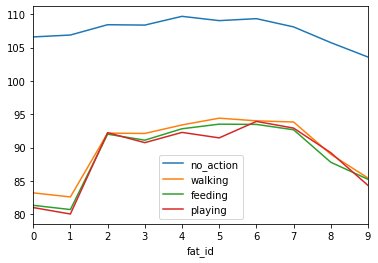

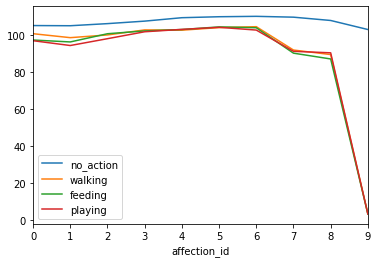

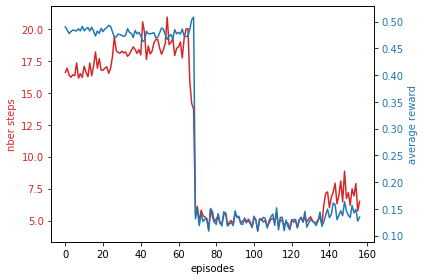

SystemError: <built-in function is_scalar> returned a result with an error set

In [28]:
# Starting with Q-learning
#for episode in trange(total_episodes):
while not convergence:
    
    epsilon = 1
    alpha = 1
    # epsilon = epsilon_initial / np.ceil( (len(all_overall_reward)+1) / 10000)
    # alpha = alpha_initial  / np.ceil( (len(all_overall_reward)+1) / 10000)
    # Something like alpha = k/(k+t) can work well
    
    dog_table = create_episode(
        Q = Q, 
        max_steps = max_steps,
        epsilon = epsilon)
    # print(dog_table)

    for t in range(len(dog_table)-1):

        state_t = get_state_q(dog_table, t)

        action_t_name = dog_table.iloc[t]['last_action_taken'] if (
            dog_table.iloc[t]['minutes_since_last_action'] == 0
        ) else 'NO ACTION'
        action_t = action_space.index(action_t_name)

        reward_t = (sum(dog_table.loc[dog_table['minute'] >= t]['happiness'])/(len(dog_table)-t))
        
        state_t_1 = get_state_q(dog_table, t + 1)

        #print(state_t, action_t_name, action_t, reward_t, state_t_1)
        #print(Q[state_t, action_t])
        Q = update(Q, state_t, reward_t, action_t, state_t_1,
                   gamma = 1,
                   alpha = alpha)
        #print(Q[state_t, action_t])
    
    overall_reward = sum(dog_table['happiness'])
    nber_steps += len(dog_table)-1
    len_steps.append(len(dog_table)-1)
    all_overall_reward.append(overall_reward)
    all_overall_reward_t.append(overall_reward/len(dog_table))
    
    # print(episode, t, overall_reward, overall_reward/t)
    if len(all_overall_reward) % 1000 == 0:
        
        all_overall_reward_plot.append(np.mean(all_overall_reward[-100:]))
        all_overall_reward_t_plot.append(np.mean(all_overall_reward_t[-100:]))
        len_steps_plot.append(np.mean(len_steps[-100:]))
        distance_q_matrices = np.linalg.norm(Q_previous - Q)
        convergence = distance_q_matrices < 0.0001
        Q_previous = Q.copy()
        
        print('Iter. {:7d} - Steps {:8d} - Eps. {:0.6f} - Alp. {:0.6f} - Dist. {:06.5f} - Total R. {:06.3f} - Avg R. {:0.3f}'.format(
            len(all_overall_reward),
            nber_steps,
            epsilon, alpha,
            distance_q_matrices,
            np.mean(all_overall_reward[-100:]),
            np.mean(all_overall_reward_t[-100:])
        ))
        intermediate_plots(len_steps_plot, all_overall_reward_t_plot)

    if len(all_overall_reward) % 10000 == 0:
        display_analyse_Q(Q)


In [26]:
for i in range(Q.shape[1]):
    print(Q[:,1])

[ 7.51404097  7.59300751  7.61445065  7.61536682  7.62713383  7.67172215
  7.52954264  7.49040426  7.08100027  3.25        7.34680713  7.17821237
  6.65971171  6.52837271  6.42068871  6.27251892  6.07204708  4.94009749
  5.00850305  3.25        7.24190414  5.21317887  4.72822562  5.57271462
  5.91728852  5.55130407  5.11808388  4.00827666  3.47475688  3.25
  6.24756297  4.82190694  5.78514015  5.62911118  5.53423712  5.17619191
  4.1858863   3.34544516  3.31270059  3.25        6.04497751  5.39820372
  4.55570278  4.47123158  4.46043498  4.01998844  3.84866196  3.32488624
  3.31960409  3.25        5.66422299  3.77889106  4.14816042  3.7784248
  3.69677727  3.68464345  3.4398748   3.30964271  3.29907695  3.25
  5.66772757  4.18454868  3.97842517  3.80483364  3.48744217  3.57767436
  3.48051017  3.33458039  3.27588442  3.25        4.89896375  3.57335303
  3.54452173  3.4771926   3.48583158  3.37093311  3.3010632   3.26291539
  3.25633247  3.25        5.09293497  3.5791555   3.41780281  3.

In [25]:
dog_table = create_episode(
        Q = Q,
        max_steps = max_steps,
        epsilon = epsilon_initial / np.ceil( (len(all_overall_reward)+1) / 1000))
dog_table

,dog_id,minute,happiness,food,fat,affection,alive,can_action_be_taken,last_action_taken,minutes_since_last_action
0,1,0,0.2,0.4,0.100,0.20,True,True,NO ACTION,0
1,1,1,0.2,0.3,0.100,0.10,True,False,PLAYING,0
2,1,2,0.1,0.2,0.090,0.28,True,True,NO ACTION,0
3,1,3,0.2,0.1,0.090,0.20,True,True,NO ACTION,1
4,1,4,0.1,0.0,0.090,0.10,True,True,NO ACTION,2
5,1,5,0.0,0.0,0.090,0.00,True,False,WALKING,0
6,1,6,0.0,0.0,0.072,0.40,False,True,NO ACTION,0


In [ ]:
sum(dog_table['happiness'])

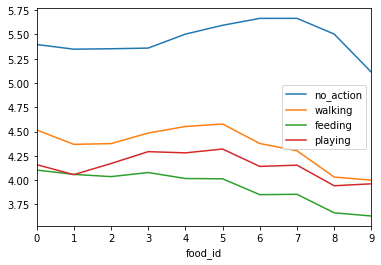

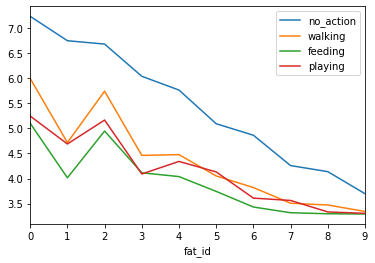

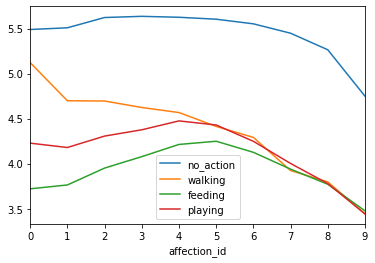

In [27]:
display_analyse_Q(Q)